# Baseline Modelling

## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [2]:
path = "/Users/saideepbunny/Projects/Application_Ranking_System"

## Reading the data

In [3]:
df = pd.read_csv(f"{path}/data/synthetic_data/synthetic_data_v2/synthetic_data_v2.csv")
df

,job_data,resume_data,label
0,Audit Manager\nMenzies LLP\nWe are looking for...,**Jennifer Oneal**\n*+1 (555) 555-5555* *|* *j...,Complete Mismatch
1,Audit Manager\nMenzies LLP\nWe are looking for...,**Christina Padilla DVM**\n\n*Email: christina...,Underwhelming
2,Audit Manager\nMenzies LLP\nWe are looking for...,**Andrew Kirby**\n*+44 00000 000000* *|* *andr...,Good Fit
3,Audit Manager\nMenzies LLP\nWe are looking for...,**Erin Hicks**\n*+1 (555) 555-5555* *|* *erin....,Overqualified
4,"Audit Manager\nOverview\nBaker Tilly US, LLP (...",**Randy Smith**\n*+1 (123) 456-7890* *|* *rand...,Complete Mismatch
...,...,...,...
3995,Test Engineer\nJob Summary:\nPerforms LAT test...,# Darren Roberts\n\n*Email*: darren.roberts@em...,Overqualified
3996,Test Engineer\nCompany Description\nMUST be au...,**Lisa Wright**\n*+1 (111) 111-1111* *|* *lisa...,Complete Mismatch
3997,Test Engineer\nCompany Description\nMUST be au...,"# Daniel Meza\n\n*Greensboro, NC* *·* *(555) 5...",Underwhelming
3998,Test Engineer\nCompany Description\nMUST be au...,"# William Torres\n\n*Greensboro, NC* *|* *will...",Good Fit


In [4]:
print("Number of rows in the dataset:", df.shape[0])
print("Number of columns in the dataset:", df.shape[1])

Number of rows in the dataset: 4000
Number of columns in the dataset: 3


In [5]:
df['label'].value_counts()

label
Complete Mismatch    1000
Underwhelming        1000
Good Fit             1000
Overqualified        1000
Name: count, dtype: int64

## Data preprocessing

In [6]:
# Download stopwords if not already downloaded
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stop_words.add("overqualified")
stop_words.add("underqualified")
stop_words.add("mismatch")
stop_words.add("good")
print(stop_words)

{'and', 'at', 's', "shouldn't", 'some', 'will', 'most', 'over', 'be', 'only', 'where', 'didn', "i'll", 'me', 'mustn', 'd', 'has', 'hadn', 'because', "weren't", "they'd", 'yourselves', 'm', 'very', 'did', 'do', 'o', 'ourselves', "he'll", "it's", 'them', 'those', 'after', 'when', 'than', 'there', "aren't", 'her', 'as', 'was', 'about', 'these', 'your', 'few', 'theirs', 'other', 'shouldn', 'his', 'on', 'himself', 'such', 'needn', 'all', 'i', "didn't", "we've", 'weren', 'mightn', 'is', "i'd", 'its', 'which', 'wasn', 'each', "they've", 'it', 'hers', "hasn't", 'by', 'for', 'from', 'through', "couldn't", 'now', 'had', 'isn', 'doesn', "shan't", "it'd", "you're", 'he', 'in', 'why', 'no', 'does', 'more', 'too', 'until', 'before', 'ours', "you'd", "won't", 'or', 'yourself', 'our', "hadn't", 'hasn', 'just', 'an', 'ain', 'with', 'nor', "mustn't", 'myself', "she'd", 'being', 'once', 'they', 'she', "they'll", 'doing', "he's", 'll', "wasn't", 'couldn', "don't", 'to', 'then', 'whom', 'were', 'this', 'sh

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/saideepbunny/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove unwanted symbols except %, $, /, and .
    text = re.sub(r"[^a-z0-9\s%$/.-]", "", text)

    # Preserve hyphens only when followed by a number (e.g., 2005-2010, 2010-present)
    text = re.sub(r"-(?!\d)", "", text)  # Remove hyphens not followed by a digit

    # Preserve GPA-like formats (e.g., 3.8/4.0)
    text = re.sub(r"(?<!\d)/|/(?!\d)", " ", text)  # Remove '/' unless between numbers

    # Remove periods (".") if they are immediately after a word but not numbers (e.g., "good." → "good", but keep 3.8)
    text = re.sub(r"\b(\w+)\.(?!\d)", r"\1", text)

    # Remove newline characters
    text = text.replace("\n", " ").replace("\r", " ")

    # Remove any show less and show more texts
    text = text.replace("show less", "").replace("show more", "")
    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    text = " ".join(word for word in text.split() if word not in stop_words)

    return text

In [8]:
df['job_data_preprocessed'] = df['job_data'].apply(preprocess_text)
df['resume_data_preprocessed'] = df['resume_data'].apply(preprocess_text)

In [9]:
print(df.iloc[100]['job_data'])
print("\n******************************************************\n")
print(df.iloc[100]['job_data_preprocessed'])

Business Development Representative
Detail-Oriented Business Development Rep
$45,000-$60,000 + Bonuses
Location: Lawrenceville, GA
Schedule: 12 pm - 8 pm
100% employer-paid Medical/ Denta/ Vision Insurance + complimentary Life Insurance
401k program, paid vacation, bonus incentive program, reimbursements for cell phone, and additional insurance offerings including Hospital Insurance, Accident Insurance, Critical Care Coverage, and Pet Insurance
Job Description:
We are seeking a highly detail-oriented and proactive Business Development Rep to join our dynamic team. As a Business Development Representative, you will play a crucial role in driving the growth and success of our company. The ideal candidate will possess exceptional attention to detail, be capable of thinking on their feet, and have the ability to cultivate strong customer relationships. This is a challenging and rewarding opportunity to contribute to the expansion of our growth.
Responsibilities:
Demonstrate exceptional com

In [10]:
print(df.iloc[100]['resume_data'])
print("\n******************************************************\n")
print(df.iloc[100]['resume_data_preprocessed'])

**Olivia Jacobs**
*Lawrenceville, GA | (555) 555-5555 | olivia.jacobs@email.com | linkedin.com/in/olivia-jacobs*

**Professional Summary**
Highly motivated and detail-oriented professional with a background in hospitality management, specializing in event planning and customer service. Proficient in managing high-pressure environments and building strong relationships with clients and stakeholders. Seeking to leverage transferable skills in a new industry.

**Skills**
*Primary Skills*: Event Planning, Customer Service, Vendor Management, Contract Negotiation, Budgeting, Project Management

*Technical Competencies*: Microsoft Office Suite, Google Workspace, Social Tables, Cvent, Concur, Salesforce (basic)

*Complementary Abilities*: Communication, Adaptability, Time Management, Problem Solving, Critical Thinking, Teamwork

**Work Experience**
**Event Coordinator, *Luxury Events Inc.* (2018-2021)**
- Managed end-to-end event planning for high-profile corporate and social events, resultin

## Modelling: TF-IDF

### Utility Functions

In [11]:
def cross_validation_scores(model, X, y, n_splits=5):
    # Define k-fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Perform cross-validation
    scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')
    
    # Print results
    print(f"Cross-validation scores: {scores}")
    print(f"Mean accuracy: {scores.mean():.4f}")
    print(f"Standard deviation: {scores.std():.4f}")
    
    
def plot_confusion_matrix(y_true, y_pred, labels=None, title="Confusion Matrix"):
    """
    Displays a confusion matrix using seaborn heatmap.

    Parameters:
    y_true : list or array
        True labels.
    y_pred : list or array
        Predicted labels.
    labels : list, optional
        Class labels for the confusion matrix.
    title : str, optional
        Title of the plot.
    """
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(8, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

### Defining X and y

In [12]:
X = df[['job_data_preprocessed', 'resume_data_preprocessed']].copy()
y = df['label']

### Train test split

In [13]:
# Assuming X contains features and y contains labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

print("Train data shape: ", X_train.shape)
print("Test data shape: ", X_test.shape)

Train data shape:  (3200, 2)
Test data shape:  (800, 2)


### Performing TF-IDF

In [14]:
# Initialize separate TF-IDF vectorizers
tfidf1 = TfidfVectorizer(max_df=0.7, min_df=0.2, max_features=5000)
tfidf2 = TfidfVectorizer(max_df=0.7, min_df=0.2, max_features=5000)

# Transform text columns separately
X_train_tfidf1 = tfidf1.fit_transform(X_train['job_data_preprocessed'])
X_train_tfidf2 = tfidf2.fit_transform(X_train['resume_data_preprocessed'])

# Combine TF-IDF features (horizontally stack them)
X_train_transformed = hstack([X_train_tfidf1, X_train_tfidf2])


# Transform text columns separately
X_test_tfidf1 = tfidf1.transform(X_test['job_data_preprocessed'])
X_test_tfidf2 = tfidf2.transform(X_test['resume_data_preprocessed'])

# Combine TF-IDF features (horizontally stack them)
X_test_transformed = hstack([X_test_tfidf1, X_test_tfidf2])

### Decision Tree Classifier

In [15]:
model = DecisionTreeClassifier(random_state=42)  # Example model
cross_validation_scores(model, X_train_transformed, y_train, n_splits=5)


Cross-validation scores: [0.8609375 0.8609375 0.865625  0.86875   0.8859375]
Mean accuracy: 0.8684
Standard deviation: 0.0092


In [16]:
# Train model on full training set
model.fit(X_train_transformed, y_train)

# Evaluate on test set
y_pred = model.predict(X_test_transformed)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
                   precision    recall  f1-score   support

Complete Mismatch       0.87      0.83      0.85       200
         Good Fit       0.82      0.81      0.81       200
    Overqualified       0.92      0.92      0.92       200
    Underwhelming       0.91      0.96      0.93       200

         accuracy                           0.88       800
        macro avg       0.88      0.88      0.88       800
     weighted avg       0.88      0.88      0.88       800


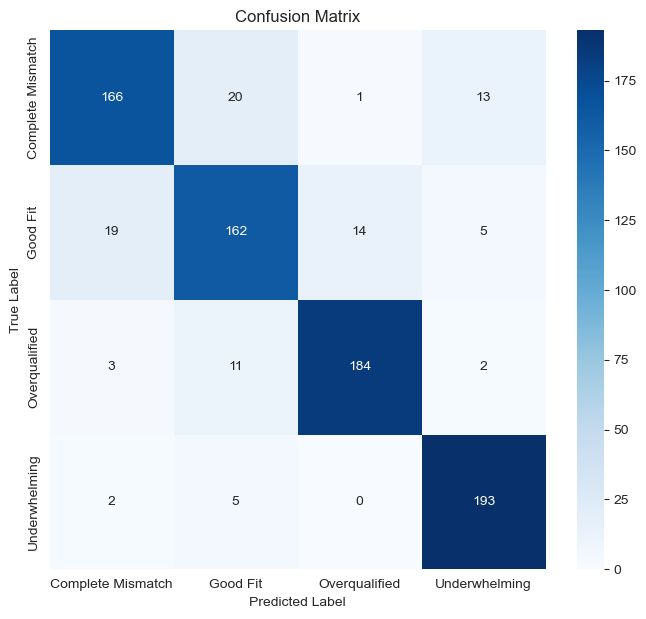

In [17]:
plot_confusion_matrix(y_test, y_pred, ["Complete Mismatch", "Good Fit", "Overqualified", "Underwhelming"])

### RandomForestClassifier

In [18]:
model = RandomForestClassifier(random_state=42)  # Example model
cross_validation_scores(model, X_train_transformed, y_train, n_splits=5)


Cross-validation scores: [0.9765625 0.9578125 0.95625   0.9609375 0.9625   ]
Mean accuracy: 0.9628
Standard deviation: 0.0072


In [19]:
# Train model on full training set
model.fit(X_train_transformed, y_train)

# Evaluate on test set
y_pred = model.predict(X_test_transformed)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
                   precision    recall  f1-score   support

Complete Mismatch       0.98      0.96      0.97       200
         Good Fit       0.95      0.96      0.96       200
    Overqualified       0.97      0.97      0.97       200
    Underwhelming       0.98      0.98      0.98       200

         accuracy                           0.97       800
        macro avg       0.97      0.97      0.97       800
     weighted avg       0.97      0.97      0.97       800


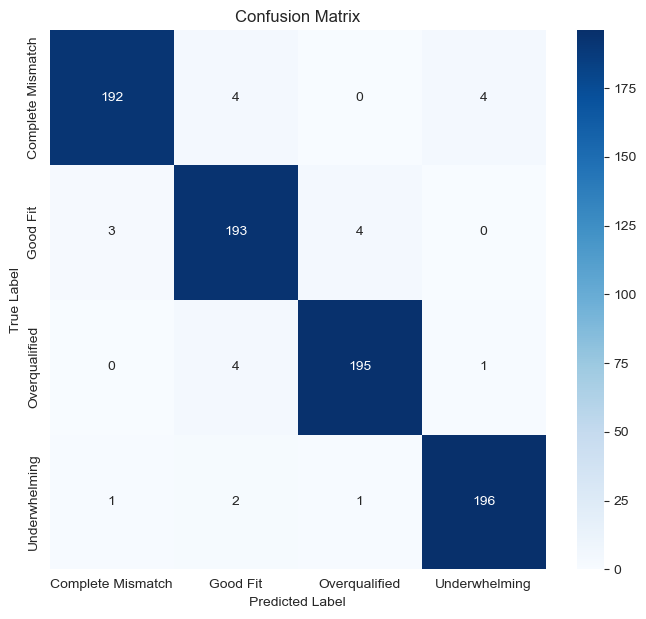

In [20]:
plot_confusion_matrix(y_test, y_pred, ["Complete Mismatch", "Good Fit", "Overqualified", "Underwhelming"])

#### Checking for most important features

Since we are using TF-IDF, words would be our features. We are trying to see if there are any features that are directly correlated to target. This gives us information if there is any Data Leakage

In [21]:
# Get Feature Importance from XGBoost
feature_importance = model.feature_importances_

# Get Feature Names
job_features = np.array(tfidf1.get_feature_names_out())  # Job description words
resume_features = np.array(tfidf2.get_feature_names_out())  # Resume words

# Split importance back into Job Description & Resume parts
job_feature_importance = feature_importance[:len(job_features)]
resume_feature_importance = feature_importance[len(job_features):]

# Create Sorted DataFrames
job_df = pd.DataFrame({'Word': job_features, 'Importance': job_feature_importance}).sort_values(by="Importance", ascending=False)
resume_df = pd.DataFrame({'Word': resume_features, 'Importance': resume_feature_importance}).sort_values(by="Importance", ascending=False)

In [22]:
job_df.head(30)

,Word,Importance
190,manager,0.001414
324,systems,0.001100
35,business,0.001093
102,ensure,0.001091
172,leadership,0.001047
290,responsible,0.001038
95,employee,0.001038
72,data,0.001036
184,maintain,0.001019
354,working,0.001003


In [23]:
resume_df.head(30)

,Word,Importance
135,seeking,0.036113
101,mentoring,0.035185
132,role,0.032524
139,skilled,0.029363
100,mentored,0.025554
145,strategic,0.025550
142,specializing,0.025377
88,leadership,0.019549
109,planning,0.019288
63,driving,0.018347


The high performance might be due to clear decision boundaries as each of the resume with different fit categories is designed to be widely different from one category to another.

### Analyzing prediction probabilities

In [24]:
# 0-Complete Mismatch
# 1-Good fit
# 2-Overqualified
# 3-Underwhelming

result_df = pd.DataFrame()
result_df['label'] = y_test
result_df['predicted_label'] = y_pred

prob_cols = ['Complete Mismatch_prob', 'Good Fit_prob', 'Overqualified_prob', 'Underwhelming_prob']
result_df[prob_cols] = model.predict_proba(X_test_transformed)
result_df

,label,predicted_label,Complete Mismatch_prob,Good Fit_prob,Overqualified_prob,Underwhelming_prob
1738,Good Fit,Good Fit,0.25,0.65,0.08,0.02
47,Overqualified,Overqualified,0.04,0.09,0.84,0.03
3900,Complete Mismatch,Complete Mismatch,0.55,0.22,0.02,0.21
2323,Overqualified,Overqualified,0.08,0.18,0.69,0.05
1450,Good Fit,Good Fit,0.03,0.44,0.39,0.14
...,...,...,...,...,...,...
1620,Complete Mismatch,Complete Mismatch,0.63,0.14,0.09,0.14
191,Overqualified,Overqualified,0.03,0.33,0.64,0.00
1254,Good Fit,Good Fit,0.10,0.49,0.29,0.12
1032,Complete Mismatch,Complete Mismatch,0.52,0.27,0.10,0.11


In [25]:
def plot_histogram(df, col, log_scale=True):
    sns.set_style("darkgrid")
    sns.histplot(data = df, x=col, bins=20, kde=True)
    plt.title(f"Distribution of {col}")
    if(log_scale):
        plt.yscale("log")
    plt.show()

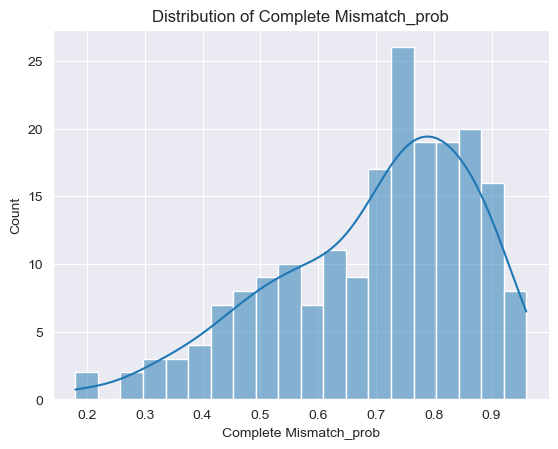

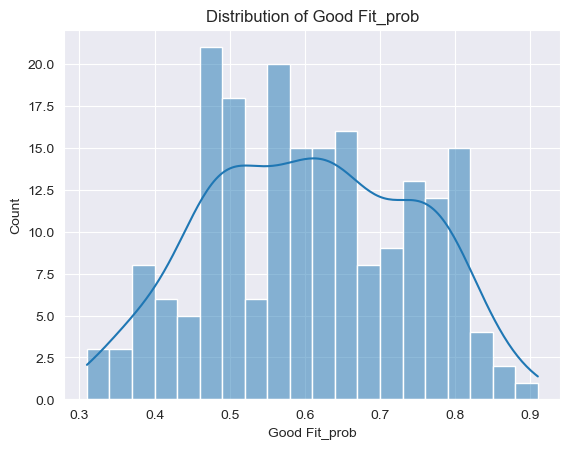

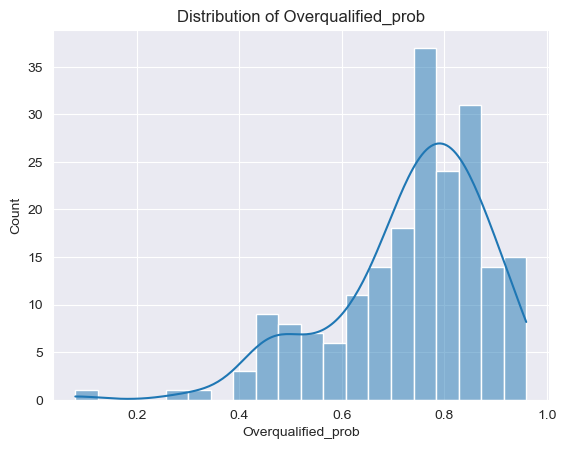

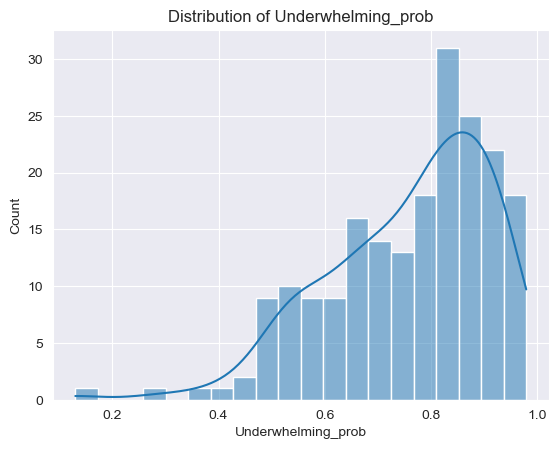

In [26]:
for i in prob_cols:
    category = i.split("_")[0]
    temp = result_df[result_df['label'] == category].copy()
    plot_histogram(temp, i, log_scale=False)

## Ablation studies

Deliberately removing input features to test model performance.

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

def select_percentage_of_columns(X, percentage, random_state=None):
    """
    Randomly selects a given percentage of columns from feature matrix X.
    
    Parameters:
    -----------
    X : numpy array or pandas DataFrame
        The feature matrix
    percentage : float
        Percentage of columns to select (between 0 and 100)
    random_state : int or None
        Random seed for reproducibility
    
    Returns:
    --------
    X_subset : same type as X
        Feature matrix with selected columns
    selected_columns : list or array
        The names or indices of selected columns
    """
    np.random.seed(random_state)
    
    if percentage <= 0 or percentage > 100:
        raise ValueError("Percentage must be between 0 and 100")
    
    # Calculate number of columns to select
    n_cols = X.shape[1]
    n_select = max(1, int(n_cols * percentage / 100))
    
    if isinstance(X, pd.DataFrame):
        # For pandas DataFrames
        all_cols = list(X.columns)
        selected_columns = np.random.choice(all_cols, size=n_select, replace=False)
        return X[selected_columns], selected_columns
    else:
        # For numpy arrays
        selected_indices = np.random.choice(n_cols, size=n_select, replace=False)
        return X[:, selected_indices], selected_indices

def evaluate_feature_percentages(X_train, y_train, X_test, y_test, percentages, n_runs=3, test_size=0.2, random_state=42):
    """
    Evaluates model performance with varying percentages of features.
    
    Parameters:
    -----------
    X : numpy array or pandas DataFrame
        Feature matrix
    y : numpy array or pandas Series
        Target labels
    percentages : list
        List of percentages of features to use
    n_runs : int
        Number of runs for each percentage (with different random features)
    test_size : float
        Proportion of data to use for testing
    random_state : int
        Random seed for reproducibility
    
    Returns:
    --------
    results_df : pandas DataFrame
        Results with mean and std accuracy for each percentage
    """
    
    results = []
    
    for percentage in percentages:
        run_accuracies = []
        
        for run in range(n_runs):
            # Select features
            X_train_subset, selected_cols = select_percentage_of_columns(
                X_train, percentage, random_state=random_state + run
            )
            
            # Use same columns for test set
            if isinstance(X_test, pd.DataFrame):
                X_test_subset = X_test[selected_cols]
            else:
                X_test_subset = X_test[:, selected_cols]
            
            # Train and evaluate model
            model = RandomForestClassifier(random_state=random_state)
            model.fit(X_train_subset, y_train)
            y_pred = model.predict(X_test_subset)
            accuracy = accuracy_score(y_test, y_pred)
            run_accuracies.append(accuracy)
        
        # Store results
        mean_acc = np.mean(run_accuracies)
        std_acc = np.std(run_accuracies)
        results.append({
            'percentage': percentage,
            'mean_accuracy': mean_acc,
            'std_accuracy': std_acc,
            'min_accuracy': np.min(run_accuracies),
            'max_accuracy': np.max(run_accuracies)
        })
    
    return pd.DataFrame(results)

def plot_feature_ablation(results_df):
    """
    Creates a line plot of feature ablation results with error bands.
    """
    plt.figure(figsize=(10, 6))
    
    # Plot mean accuracy line
    plt.plot(
        results_df['percentage'], 
        results_df['mean_accuracy'] * 100, 
        'o-', 
        color='blue', 
        linewidth=2,
        label='Mean Accuracy'
    )
    
    # Plot error bands
    plt.fill_between(
        results_df['percentage'],
        (results_df['mean_accuracy'] - results_df['std_accuracy']) * 100,
        (results_df['mean_accuracy'] + results_df['std_accuracy']) * 100,
        color='blue', 
        alpha=0.2,
        label='± 1 std dev'
    )
    
    # Add min/max range
    plt.fill_between(
        results_df['percentage'],
        results_df['min_accuracy'] * 100,
        results_df['max_accuracy'] * 100,
        color='gray', 
        alpha=0.1,
        label='Min-Max Range'
    )
    
    # Customize plot
    plt.xlabel('Percentage of Features Used (%)', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.title('Model Performance vs. Feature Percentage', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='lower right')
    plt.tight_layout()

    # Show plot
    plt.show()



In [28]:
# Define percentages to test (10%, 20%, ..., 100%)
percentages = [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    
# Run evaluation
results = evaluate_feature_percentages(X_train_transformed, y_train, X_test_transformed, y_test, percentages, n_runs=5)
results

,percentage,mean_accuracy,std_accuracy,min_accuracy,max_accuracy
0,1,0.28525,0.093205,0.15125,0.37750
1,5,0.56225,0.103927,0.37125,0.65875
2,10,0.70125,0.034920,0.63750,0.73250
3,20,0.79075,0.046968,0.74375,0.87875
4,30,0.85200,0.038035,0.80250,0.91875
5,40,0.89150,0.033386,0.84250,0.94750
6,50,0.92475,0.032676,0.86250,0.95500
7,60,0.93125,0.022735,0.88750,0.95125
8,70,0.94250,0.017906,0.90750,0.95750
9,80,0.94725,0.008993,0.93500,0.95875


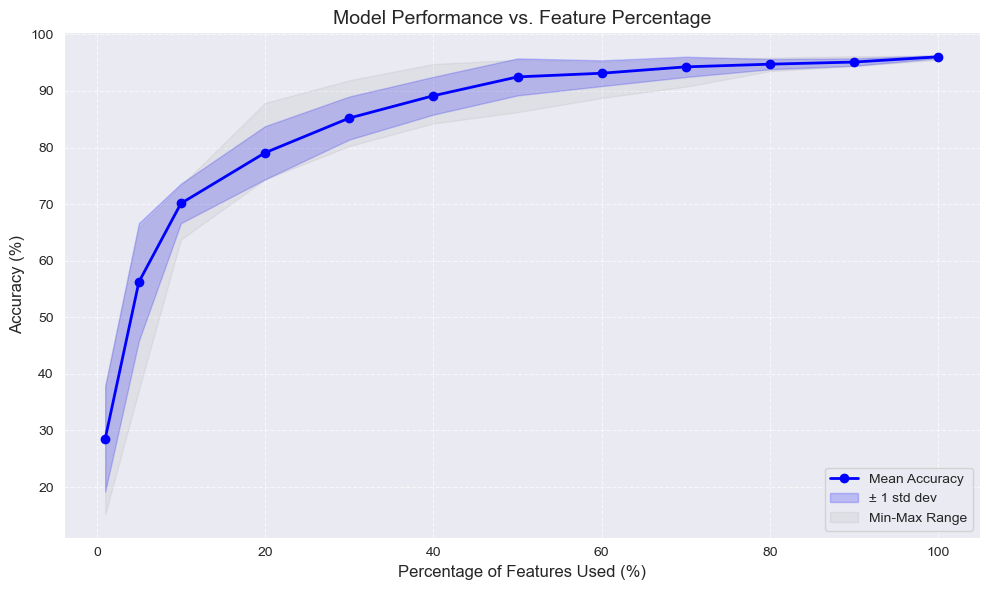

In [29]:
# Plot results
plot_feature_ablation(results)

## Final thoughts

TF-IDF is not a reliable method to predict classes. This is because, if the features that are present in the training set are absent in the test data or real world the model would fail in generalization. 

Using more robust text embeddings like using Sentence transformers gives more robust results.